In [2]:
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader

import dataclasses
from typing import Generator
from datetime import datetime

from hydra import compose, initialize
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from dataloaders.aurora_dataload import LargeClimateDataset, aurora_batch_collate
from utils import seed_everything
from bfm_finetune.paths import REPO_FOLDER, STORAGE_DIR

from aurora import Aurora, Batch, Metadata, Aurora12hPretrained

seed_everything(42)

STORAGE_DIR: /projects/prjs1134/data/projects/biodt/storage


In [12]:
# Batch path (overriden) # bfm_cfg.evaluation.test_data
test_data_path = str(STORAGE_DIR / "monthly_batches" / "batches") # COMPLETE BATCHES
stats_path = str(
    STORAGE_DIR
    / "monthly_batches"
    / "statistics"
    / "monthly_batches_stats_splitted_channels.json"
)

bfm_config_path = REPO_FOLDER / "bfm-model/bfm_model/bfm/configs"
cwd = Path(os.getcwd())
bfm_config_path = str(bfm_config_path.relative_to(cwd))
bfm_config_path = f"../bfm-model/bfm_model/bfm/configs"
overrides = ["data.scaling.enabled=False"] # We provide unnscaled dataset, Aurora does the normalization
with initialize(version_base=None, config_path=bfm_config_path, job_name="test_app"):
    bfm_cfg = compose(config_name="train_config.yaml", overrides=overrides)
print(bfm_cfg)


test_dataset = LargeClimateDataset(
    data_dir=test_data_path,
    scaling_settings=bfm_cfg.data.scaling,
    num_species=28,
    atmos_levels=bfm_cfg.data.atmos_levels,
    model_patch_size=bfm_cfg.model.patch_size,
    max_files=234, # TODO Change this to iterate over the whole dataset!
    mode="finetune"
)
# print(test_dataset[0])
print("Reading test data from :", test_data_path)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=0,
    collate_fn = aurora_batch_collate,
    drop_last=True,
    shuffle=False,
)

{'model': {'T': 2, 'surface_vars': ['t2m', 'msl', 'slt', 'z', 'u10', 'v10', 'lsm'], 'edaphic_vars': ['swvl1', 'swvl2', 'stl1', 'stl2'], 'atmos_vars': ['z', 't', 'u', 'v', 'q'], 'climate_vars': ['smlt', 'tp', 'csfr', 'avg_sdswrf', 'avg_snswrf', 'avg_snlwrf', 'avg_tprate', 'avg_sdswrfcs', 'sd', 't2m', 'd2m'], 'species_vars': ['1340361', '1340503', '1536449', '1898286', '1920506', '2430567', '2431885', '2433433', '2434779', '2435240', '2435261', '2437394', '2441454', '2473958', '2491534', '2891770', '3034825', '4408498', '5218786', '5219073', '5219173', '5219219', '5844449', '8002952', '8077224', '8894817', '8909809', '9809229'], 'vegetation_vars': ['NDVI'], 'land_vars': ['Land'], 'agriculture_vars': ['Agriculture', 'Arable', 'Cropland'], 'forest_vars': ['Forest'], 'redlist_vars': ['RLI'], 'misc_vars': ['avg_slhtf', 'avg_pevr'], 'H': 160, 'W': 280, 'num_latent_tokens': 8, 'backbone': 'swin', 'patch_size': 4, 'embed_dim': 256, 'num_heads': 16, 'head_dim': 64, 'depth': 3, 'swin_backbone_siz

In [13]:
print(f"Total length of samples {len(test_dataset)}")
batch = next(iter(test_dataloader))
for name, t in batch.atmos_vars.items():
    print(name, t.shape)


Total length of samples 234
z torch.Size([1, 2, 13, 160, 280])
t torch.Size([1, 2, 13, 160, 280])
u torch.Size([1, 2, 13, 160, 280])
v torch.Size([1, 2, 13, 160, 280])
q torch.Size([1, 2, 13, 160, 280])


In [14]:
# model = Aurora12hPretrained(use_lora=True)  # The pretrained version does not use LoRA.
# model.load_checkpoint(strict=False)
model = Aurora(use_lora=False)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")
# model.load_checkpoint()
model.eval()
model = model.to("cuda")
model

Aurora(
  (encoder): Perceiver3DEncoder(
    (surf_mlp): MLP(
      (net): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.0, inplace=False)
      )
    )
    (surf_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (pos_embed): Linear(in_features=512, out_features=512, bias=True)
    (scale_embed): Linear(in_features=512, out_features=512, bias=True)
    (lead_time_embed): Linear(in_features=512, out_features=512, bias=True)
    (absolute_time_embed): Linear(in_features=512, out_features=512, bias=True)
    (atmos_levels_embed): Linear(in_features=512, out_features=512, bias=True)
    (surf_token_embeds): LevelPatchEmbed(
      (weights): ParameterDict(
          (10u): Parameter containing: [torch.cuda.FloatTensor of size 512x1x2x4x4 (cuda:0)]
          (10v): Parameter containing: [torch.cuda.FloatTensor of siz

In [15]:
def _match_batch(tensor: torch.Tensor, target_len: int) -> torch.Tensor:
    """
    Ensure tensor.shape[0] == target_len. If tensor has a singleton
    batch dim (size 1) it is repeated; otherwise it is returned unchanged.
    Raises if both sides differ and neither is singleton.
    """
    B = tensor.shape[0]
    if B == target_len:
        return tensor
    if B == 1:
        reps = [target_len] + [1] * (tensor.ndim - 1)
        return tensor.repeat(*reps)
    raise ValueError(f"Cannot broadcast: tensor B={B} vs target B={target_len}")


def rollout(model: Aurora, batch: Batch, steps: int) -> Generator[Batch, None, None]:
    """Perform a roll-out to make long-term predictions.

    Args:
        model (:class:`aurora.model.aurora.Aurora`): The model to roll out.
        batch (:class:`aurora.batch.Batch`): The batch to start the roll-out from.
        steps (int): The number of roll-out steps.

    Yields:
        :class:`aurora.batch.Batch`: The prediction after every step.
    """
    # We will need to concatenate data, so ensure that everything is already of the right form.
    batch = model.batch_transform_hook(batch)  # This might modify the available variables.
    # Use an arbitary parameter of the model to derive the data type and device.
    p = next(model.parameters())
    batch = batch.type(p.dtype)
    batch = batch.crop(model.patch_size)
    batch = batch.to(p.device)

    for _ in range(steps):
        pred = model.forward(batch)

        yield pred
        batch = dataclasses.replace(
            pred,
            surf_vars={
                k: torch.cat(
                    [
                        _match_batch(batch.surf_vars[k][:, 1:], v.shape[0]),  # history (T-1) aligned
                        v                                                    # new step (T = 1)
                    ],
                    dim=1
                )
                for k, v in pred.surf_vars.items()
            },
            atmos_vars={
                k: torch.cat(
                    [
                        _match_batch(batch.atmos_vars[k][:, 1:], v.shape[0]),
                        v
                    ],
                    dim=1
                )
                for k, v in pred.atmos_vars.items()
            },
        )



In [16]:
with torch.inference_mode():
    # for batch in test_dataloader:
    batch = next(iter(test_dataloader))
    print("Input timestamp", batch.metadata.time)
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=20)]

print(len(preds))
print("Prediction timestamp", preds[-1].metadata.time)
print(preds[-1])


Input timestamp (datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 2, 1, 0, 0))
20
Prediction timestamp (datetime.datetime(2000, 1, 6, 0, 0), datetime.datetime(2000, 2, 6, 0, 0))
Batch(surf_vars={'2t': tensor([[[[274.0126, 274.1703, 274.2560,  ..., 271.0458, 271.1241, 271.5292],
          [272.6088, 272.7747, 272.8659,  ..., 270.6356, 270.8436, 271.1865],
          [272.4473, 272.9100, 273.0749,  ..., 270.9911, 271.0982, 271.2882],
          ...,
          [278.5762, 277.8864, 275.8735,  ..., 279.5868, 279.7119, 279.7324],
          [273.6451, 273.4600, 273.1350,  ..., 279.7039, 279.8372, 279.8365],
          [268.9263, 269.0964, 270.8102,  ..., 279.7112, 279.8187, 279.8600]]],


        [[[273.6898, 273.8419, 273.9242,  ..., 271.0377, 271.0942, 271.4695],
          [272.2728, 272.4011, 272.4733,  ..., 270.5761, 270.7695, 271.0905],
          [272.0825, 272.5017, 272.6447,  ..., 270.8578, 270.9699, 271.1552],
          ...,
          [278.5468, 277.7183, 275.4593,  ..., 279.

In [17]:
target = preds[-1]
target.surf_vars["2t"].shape # t2m # THIS ONE WE NEED ! The temperature

torch.Size([2, 1, 160, 280])

In [18]:
PRED_ROOT = Path("predictions")

def save_last_prediction(pred: Batch):
    """Save *one* Batch object to <PRED_ROOT>/<YYYY-MM>.pt"""
    month_key = pred.metadata.time[-1].strftime("%Y-%m")  # take last timestep in tuple
    path = PRED_ROOT / f"{month_key}.pt"
    path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(pred, path)
    print(f"Saved {path}")

def load_prediction(month_key: str) -> Batch:
    """Load a saved Batch, e.g. month_key='2000-01'."""
    path = PRED_ROOT / f"{month_key}.pt"
    if not path.exists():
        raise FileNotFoundError(path)
    return torch.load(path, map_location="cpu", weights_only=False)

    

In [19]:
model.eval().to("cuda")

with torch.inference_mode():
    for batch in test_dataloader:
        print("Input timestamp", batch.metadata.time)

        # run one-month forecast (2 x 6-hour steps x ~30 days = 120 steps)  
        preds = [p.to("cpu") for p in rollout(model, batch, steps=1)]
        last_pred = preds[-1]

        save_last_prediction(last_pred)

Input timestamp (datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 2, 1, 0, 0))
Saved predictions/2000-02.pt
Input timestamp (datetime.datetime(2000, 2, 1, 0, 0), datetime.datetime(2000, 3, 1, 0, 0))
Saved predictions/2000-03.pt
Input timestamp (datetime.datetime(2000, 3, 1, 0, 0), datetime.datetime(2000, 4, 1, 0, 0))
Saved predictions/2000-04.pt
Input timestamp (datetime.datetime(2000, 4, 1, 0, 0), datetime.datetime(2000, 5, 1, 0, 0))
Saved predictions/2000-05.pt
Input timestamp (datetime.datetime(2000, 5, 1, 0, 0), datetime.datetime(2000, 6, 1, 0, 0))
Saved predictions/2000-06.pt
Input timestamp (datetime.datetime(2000, 6, 1, 0, 0), datetime.datetime(2000, 7, 1, 0, 0))
Saved predictions/2000-07.pt
Input timestamp (datetime.datetime(2000, 7, 1, 0, 0), datetime.datetime(2000, 8, 1, 0, 0))
Saved predictions/2000-08.pt
Input timestamp (datetime.datetime(2000, 8, 1, 0, 0), datetime.datetime(2000, 9, 1, 0, 0))
Saved predictions/2000-09.pt
Input timestamp (datetime.datetime(2000,

forecast valid time: (datetime.datetime(2000, 2, 1, 6, 0), datetime.datetime(2000, 3, 1, 6, 0))
Temp shape torch.Size([2, 1, 160, 280])


Text(0.5, 1.0, '2-m temp')

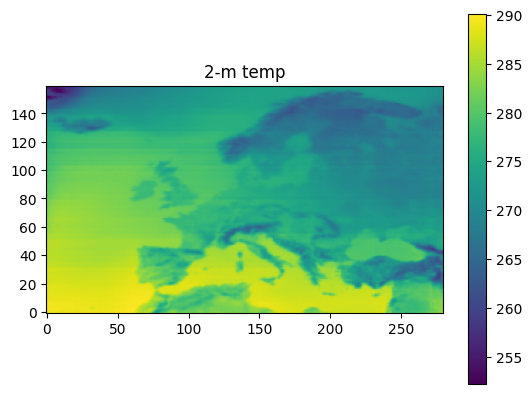

In [11]:
pred = load_prediction("2000-03") # load March forecast
print("forecast valid time:", pred.metadata.time)

# quick look at surface temperature field of the second time step
t2 = pred.surf_vars["2t"]
print("Temp shape", t2.shape)
plt.imshow(t2[0][0], origin="lower"); plt.colorbar(); plt.title("2-m temp")

In [21]:
import xarray as xr
ds = xr.open_dataset("/gpfs/work1/0/prjs1134/data/projects/biodt/storage/finetune/chelsa/chelsa_bfm_latents_downsampled.nc")
print(ds)

<xarray.Dataset> Size: 31GB
Dimensions:          (time: 234, pixel: 64400, embedding_dim: 256,
                      target_pixel: 44800, variable: 2)
Coordinates:
  * time             (time) datetime64[ns] 2kB 2000-01-01 ... 2019-06-01
  * embedding_dim    (embedding_dim) int64 2kB 0 1 2 3 4 ... 251 252 253 254 255
  * pixel            (pixel) int64 515kB 0 1 2 3 4 ... 64396 64397 64398 64399
  * variable         (variable) <U3 24B 'tas' 'pr'
Dimensions without coordinates: target_pixel
Data variables:
    encoder_output   (time, pixel, embedding_dim) float32 15GB ...
    backbone_output  (time, pixel, embedding_dim) float32 15GB ...
    target           (time, target_pixel, variable) float64 168MB ...
    decoder_input    (time, target_pixel, variable) float32 84MB ...


In [32]:
def debug_time_coordinates(ds, pred_root=PRED_ROOT):
    """Debug time coordinates to understand the mismatch."""
    
    # Check target dataset times
    print("=== TARGET DATASET TIMES ===")
    target_times = pd.to_datetime(ds.time.values)
    print(f"Target time range: {target_times.min()} to {target_times.max()}")
    print(f"Target time count: {len(target_times)}")
    print(f"First 5 target times: {target_times[:5]}")
    print(f"Last 5 target times: {target_times[-5:]}")
    
    # Check Aurora prediction times
    print("\n=== AURORA PREDICTION TIMES ===")
    pred_files = list(pred_root.glob("*.pt"))
    if not pred_files:
        print("No prediction files found!")
        return
    
    pred_files.sort(key=lambda x: x.stem)
    aurora_timestamps = []
    
    for pred_file in pred_files[:5]:  # Check first 5 files
        pred = torch.load(pred_file, map_location="cpu", weights_only=False)
        timestamp = pred.metadata.time[1]  # forecast time
        aurora_timestamps.append(timestamp)
        print(f"File: {pred_file.name}, Forecast time: {timestamp}")
    
    aurora_times = pd.to_datetime(aurora_timestamps)
    print(f"Aurora time range (first 5): {aurora_times.min()} to {aurora_times.max()}")
    
    # Check for overlap
    print("\n=== OVERLAP CHECK ===")
    print(f"Target times are datetime64[ns]: {target_times.dtype}")
    print(f"Aurora times are datetime: {type(aurora_times[0])}")
    
    # Try to find any overlaps
    target_set = set(target_times.astype('datetime64[s]').astype(str))
    aurora_set = set(aurora_times.astype('datetime64[s]').astype(str))
    
    print(f"Common periods (as strings): {len(target_set.intersection(aurora_set))}")
    
    return target_times, aurora_times

# Debug the time coordinates
target_times, aurora_times = debug_time_coordinates(ds, PRED_ROOT)

=== TARGET DATASET TIMES ===
Target time range: 2000-01-01 00:00:00 to 2019-06-01 00:00:00
Target time count: 234
First 5 target times: DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01'],
              dtype='datetime64[ns]', freq=None)
Last 5 target times: DatetimeIndex(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01'],
              dtype='datetime64[ns]', freq=None)

=== AURORA PREDICTION TIMES ===
File: 2000-02.pt, Forecast time: 2000-02-01 06:00:00
File: 2000-03.pt, Forecast time: 2000-03-01 06:00:00
File: 2000-04.pt, Forecast time: 2000-04-01 06:00:00
File: 2000-05.pt, Forecast time: 2000-05-01 06:00:00
File: 2000-06.pt, Forecast time: 2000-06-01 06:00:00
Aurora time range (first 5): 2000-02-01 06:00:00 to 2000-06-01 06:00:00

=== OVERLAP CHECK ===
Target times are datetime64[ns]: datetime64[ns]
Aurora times are datetime: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Common periods (as strin

In [38]:
import pandas as pd
import numpy as np
import xarray as xr

def create_tas_aurora_comparison_fixed(ds, pred_root=PRED_ROOT, output_path="tas_aurora_comparison.nc"):
    """
    Create a new NetCDF file with target 'tas' data and Aurora predictions.
    Handles the 6-hour time offset between target (00:00) and Aurora (06:00).
    """
    
    # Extract only the 'tas' target data
    tas_target = ds["target"].sel(variable="tas")  # Shape: (time, target_pixel)
    
    # Find all .pt files
    pred_files = list(pred_root.glob("*.pt"))
    if not pred_files:
        print("No prediction files found!")
        return None
    
    pred_files.sort(key=lambda x: x.stem)
    
    aurora_predictions = []
    aurora_timestamps = []
    
    print(f"Processing {len(pred_files)} prediction files...")
    
    for pred_file in pred_files:
        pred = torch.load(pred_file, map_location="cpu", weights_only=False)
        
        # Extract forecast temperature 
        # Shape: [batch=2, time=1, lat=160, lon=280]
        t2m = pred.surf_vars["2t"][1, 0].numpy()  # Take forecast timestep [160, 280]
        
        # Get the forecast timestamp and normalize to midnight for comparison
        forecast_time = pred.metadata.time[1]  # e.g., 2000-02-01 06:00:00
        normalized_time = forecast_time.replace(hour=0, minute=0, second=0, microsecond=0)  # 2000-02-01 00:00:00
        
        aurora_predictions.append(t2m)
        aurora_timestamps.append(normalized_time)
    
    # Stack predictions
    aurora_data = np.stack(aurora_predictions, axis=0)  # [time, lat, lon]
    aurora_time_coords = pd.to_datetime(aurora_timestamps)
    
    # Create Aurora lat/lon coordinates (Aurora 0.25° resolution)
    aurora_lat = np.linspace(90, -90, 160)
    aurora_lon = np.linspace(-180, 180, 280)
    
    # Create Aurora predictions DataArray
    aurora_da = xr.DataArray(
        aurora_data,
        dims=["time", "lat", "lon"],
        coords={
            "time": aurora_time_coords,
            "lat": aurora_lat,
            "lon": aurora_lon,
        },
        name="aurora_2t",
        attrs={
            "long_name": "Aurora model 2-meter temperature predictions",
            "units": "K",
            "description": "Aurora 2m temperature forecasts (normalized to midnight)",
            "source": "Microsoft Aurora weather model",
            "original_forecast_time": "06:00 UTC (normalized to 00:00 for comparison)"
        }
    )
    
    # Now find overlapping times
    target_times = pd.to_datetime(tas_target.time.values)
    common_times = np.intersect1d(target_times, aurora_time_coords)
    
    print(f"Found {len(common_times)} overlapping time periods")
    
    if len(common_times) > 0:
        # Subset both datasets to common times
        tas_subset = tas_target.sel(time=common_times)
        aurora_subset = aurora_da.sel(time=common_times)
        
        # Create aligned dataset
        new_ds = xr.Dataset({
            "chelsa_tas": tas_subset,
            "aurora_2t": aurora_subset
        })
        
        alignment_note = f"Aligned to {len(common_times)} common time periods"
    else:
        # Keep separate time dimensions if no overlap
        new_ds = xr.Dataset({
            "chelsa_tas": tas_target,
            "aurora_2t": aurora_da.rename({"time": "aurora_time"})
        })
        
        alignment_note = "No time alignment - separate time dimensions"
    
    # Add attributes
    new_ds["chelsa_tas"].attrs = {
        "long_name": "CHELSA target 2-meter temperature",
        "units": "K",
        "description": "Target temperature values from CHELSA dataset (pixel format)",
        "source": "CHELSA climate data"
    }
    
    new_ds["aurora_2t"].attrs = {
        "long_name": "Aurora model 2-meter temperature predictions",
        "units": "K",
        "description": "Aurora 2m temperature forecasts (normalized to midnight)",
        "source": "Microsoft Aurora weather model",
        "original_forecast_time": "06:00 UTC (normalized to 00:00 for comparison)"
    }
    
    # Add global attributes
    new_ds.attrs = {
        "title": "CHELSA TAS vs Aurora 2T Comparison",
        "description": "CHELSA target and Aurora predicted 2-meter temperature comparison",
        "created_on": pd.Timestamp.now().isoformat(),
        "time_alignment": alignment_note,
        "target_time_range": f"{target_times.min()} to {target_times.max()}",
        "aurora_time_range": f"{aurora_time_coords.min()} to {aurora_time_coords.max()}",
        "chelsa_shape": f"{tas_target.shape}",
        "aurora_shape": f"{aurora_da.shape}",
        "spatial_format": "CHELSA: pixel-based, Aurora: lat/lon grid (160x280)",
        "note": "Aurora forecast times (06:00) normalized to midnight for comparison"
    }
    
    # Save to NetCDF
    output_path = Path(output_path)
    new_ds.to_netcdf(output_path)
    print(f"Saved comparison dataset to: {output_path}")
    print(f"Dataset contents:")
    for var_name, var_data in new_ds.data_vars.items():
        print(f"  - {var_name}: {var_data.shape}")
    
    return new_ds

# Create the comparison dataset with named variables
comparison_ds = create_tas_aurora_comparison_fixed(ds, PRED_ROOT, "chelsa_aurora_comparison.nc")
print("\nFinal dataset structure:")
print(comparison_ds)

Processing 234 prediction files...
Found 233 overlapping time periods
Saved comparison dataset to: chelsa_aurora_comparison.nc
Dataset contents:
  - chelsa_tas: (233, 44800)
  - aurora_2t: (233, 160, 280)

Final dataset structure:
<xarray.Dataset> Size: 125MB
Dimensions:     (time: 233, target_pixel: 44800, lat: 160, lon: 280)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2000-02-01 2000-03-01 ... 2019-06-01
    variable    <U3 12B 'tas'
  * lat         (lat) float64 1kB 90.0 88.87 87.74 86.6 ... -87.74 -88.87 -90.0
  * lon         (lon) float64 2kB -180.0 -178.7 -177.4 ... 177.4 178.7 180.0
Dimensions without coordinates: target_pixel
Data variables:
    chelsa_tas  (time, target_pixel) float64 84MB ...
    aurora_2t   (time, lat, lon) float32 42MB 289.3 289.5 289.5 ... 277.3 277.5
Attributes:
    title:              CHELSA TAS vs Aurora 2T Comparison
    description:        CHELSA target and Aurora predicted 2-meter temperatur...
    created_on:         2025-07-07T13:36:16.4

In [40]:
ds_final = xr.open_dataset("/home/tkhan/bfm-finetune/bfm_finetune/predictions/chelsa_aurora_comparison.nc")
print(ds_final)

<xarray.Dataset> Size: 125MB
Dimensions:     (time: 233, target_pixel: 44800, lat: 160, lon: 280)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2000-02-01 2000-03-01 ... 2019-06-01
    variable    <U3 12B ...
  * lat         (lat) float64 1kB 90.0 88.87 87.74 86.6 ... -87.74 -88.87 -90.0
  * lon         (lon) float64 2kB -180.0 -178.7 -177.4 ... 177.4 178.7 180.0
Dimensions without coordinates: target_pixel
Data variables:
    chelsa_tas  (time, target_pixel) float64 84MB ...
    aurora_2t   (time, lat, lon) float32 42MB ...
Attributes:
    title:              CHELSA TAS vs Aurora 2T Comparison
    description:        CHELSA target and Aurora predicted 2-meter temperatur...
    created_on:         2025-07-07T13:36:16.440285
    time_alignment:     Aligned to 233 common time periods
    target_time_range:  2000-01-01 00:00:00 to 2019-06-01 00:00:00
    aurora_time_range:  2000-02-01 00:00:00 to 2019-07-01 00:00:00
    chelsa_shape:       (234, 44800)
    aurora_shape:       (23

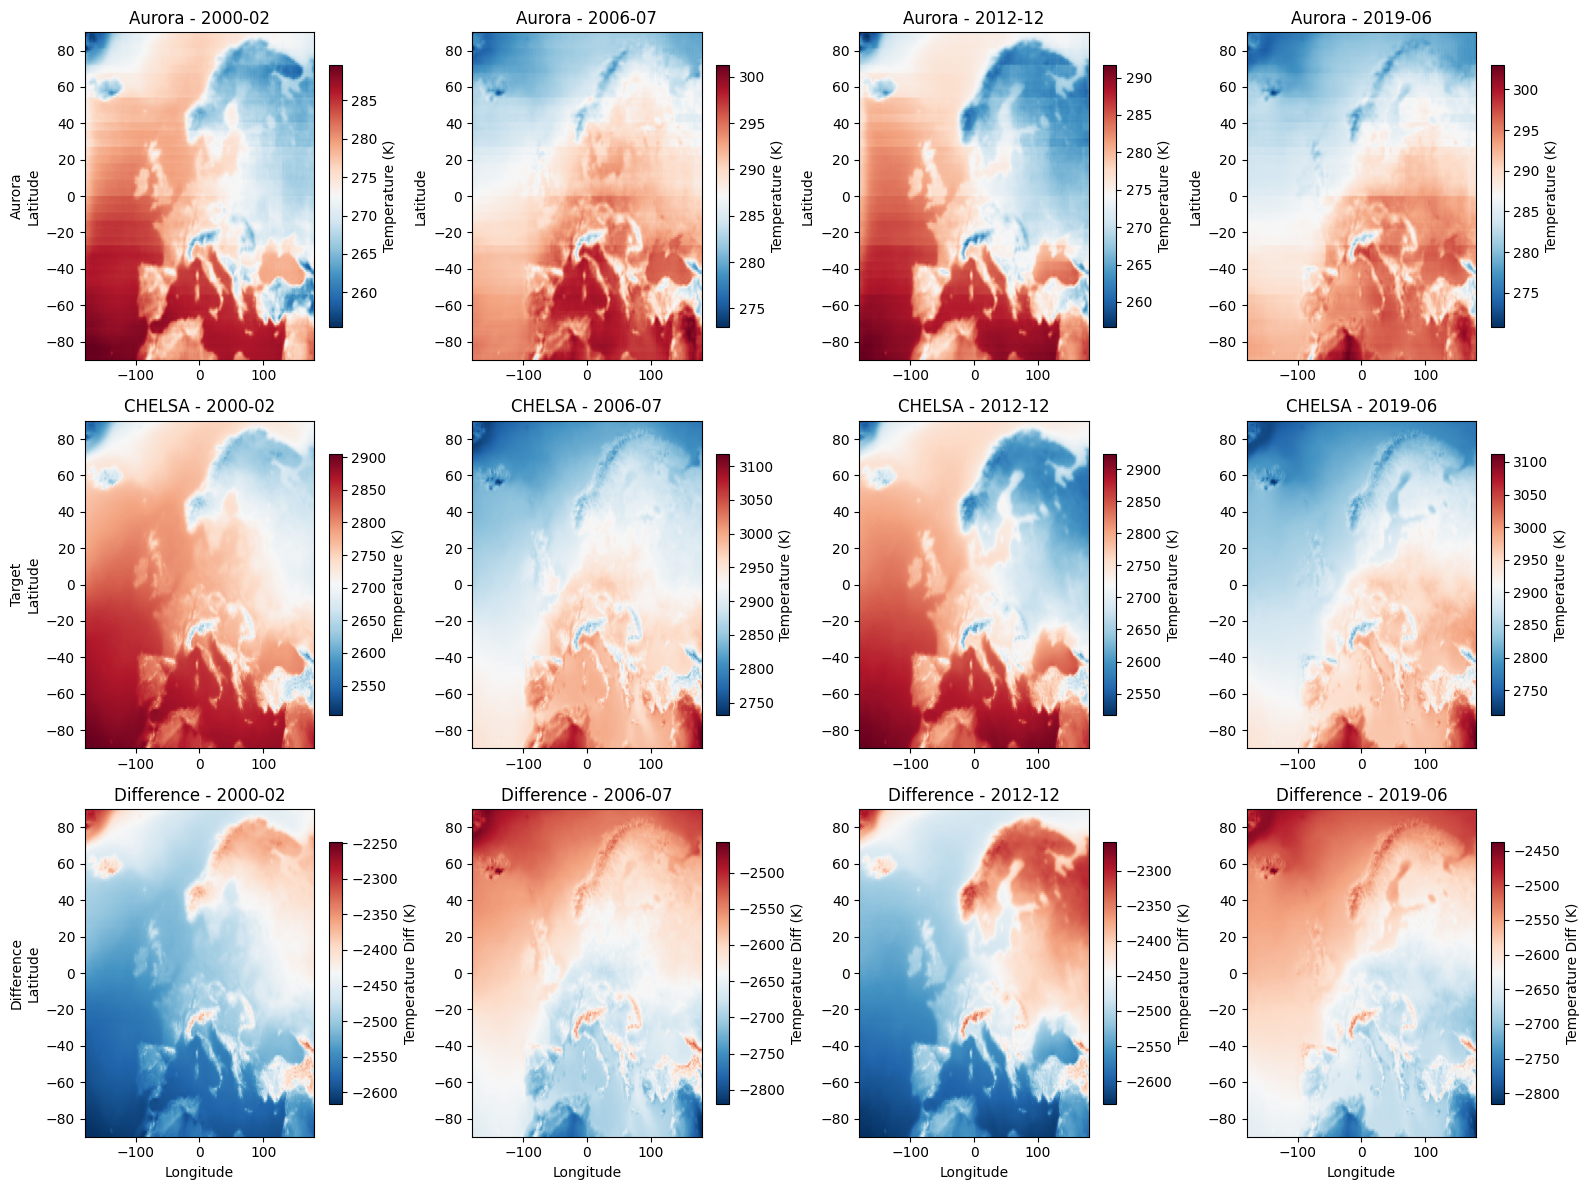

In [42]:
def plot_comparison_maps(ds, num_periods=4, figsize=(16, 12)):
    """Plot spatial maps comparing target and Aurora predictions for 4 time periods."""
    
    # Select 4 time periods evenly spaced
    time_indices = np.linspace(0, len(ds.time)-1, num_periods, dtype=int)
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, num_periods, figsize=figsize)
    
    # Aurora spatial coordinates (assuming 160x280 grid)
    aurora_lat = np.linspace(90, -90, 160)
    aurora_lon = np.linspace(-180, 180, 280)
    
    for i, time_idx in enumerate(time_indices):
        # Get timestamp
        timestamp = pd.to_datetime(ds.time.isel(time=time_idx).values)
        
        # Get Aurora data and reshape to spatial grid
        aurora_data = ds.aurora_2t.isel(time=time_idx).values.reshape(160, 280)
        
        # For target data, we need to reshape it to match Aurora's grid
        # Since target is in pixel format, we'll reshape it to the same grid
        target_data = ds.chelsa_tas.isel(time=time_idx).values.reshape(160, 280)
        
        # Calculate difference
        diff_data = aurora_data - target_data
        
        # Plot Aurora predictions
        im1 = axes[0, i].imshow(aurora_data, origin='lower', cmap='RdBu_r', 
                               extent=[-180, 180, -90, 90], aspect='auto')
        axes[0, i].set_title(f'Aurora - {timestamp.strftime("%Y-%m")}')
        axes[0, i].set_ylabel('Latitude')
        if i == 0:
            axes[0, i].set_ylabel('Aurora\nLatitude')
        plt.colorbar(im1, ax=axes[0, i], shrink=0.8, label='Temperature (K)')
        
        # Plot target data
        im2 = axes[1, i].imshow(target_data, origin='lower', cmap='RdBu_r',
                               extent=[-180, 180, -90, 90], aspect='auto')
        axes[1, i].set_title(f'CHELSA - {timestamp.strftime("%Y-%m")}')
        if i == 0:
            axes[1, i].set_ylabel('Target\nLatitude')
        plt.colorbar(im2, ax=axes[1, i], shrink=0.8, label='Temperature (K)')
        
        # Plot difference
        im3 = axes[2, i].imshow(diff_data, origin='lower', cmap='RdBu_r',
                               extent=[-180, 180, -90, 90], aspect='auto')
        axes[2, i].set_title(f'Difference - {timestamp.strftime("%Y-%m")}')
        axes[2, i].set_xlabel('Longitude')
        if i == 0:
            axes[2, i].set_ylabel('Difference\nLatitude')
        plt.colorbar(im3, ax=axes[2, i], shrink=0.8, label='Temperature Diff (K)')
    
    plt.tight_layout()
    plt.show()

# Create the maps
plot_comparison_maps(ds_final)